In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.radarmodule as radar
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
from pyCRMtools.pycaps import arps_read
from pyCRMtools.pycaps import pycaps_fields
from pyCRMtools.pycaps import calvars_radar as pycaps_radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PIPS_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/TriPIPS/2019'
parsivel_combined_filename = 'parsivel_combined_TriPIPS_092719_TriPIPS_10s.nc'
parsivel_combined_path = os.path.join(PIPS_dir, parsivel_combined_filename)
parsivel_combined_ds = xr.open_dataset(parsivel_combined_path)

In [4]:
print(parsivel_combined_ds)

<xarray.Dataset>
Dimensions:            (diameter_bin: 32, fallspeed_bin: 32, fields: 12, parameter: 3, time: 8640)
Coordinates:
    diameter           (diameter_bin) float64 ...
    fallspeed          (fallspeed_bin) float64 ...
  * fields             (fields) object 'reflectivity' ... 'cross_correlation_ratio'
    max_diameter       (diameter_bin) float64 ...
    max_fallspeeds     (fallspeed_bin) float64 ...
    min_diameter       (diameter_bin) float64 ...
    min_fallspeeds     (fallspeed_bin) float64 ...
  * parameter          (parameter) object 'N0' 'lamda' 'alpha'
  * time               (time) datetime64[ns] 2019-09-27T00:00:10 ... 2019-09-28
Dimensions without coordinates: diameter_bin, fallspeed_bin
Data variables:
    DSD_MM234          (parameter, time) float64 ...
    DSD_MM24           (parameter, time) float64 ...
    DSD_MM246          (parameter, time) float64 ...
    DSD_MM346          (parameter, time) float64 ...
    DSD_MM36           (parameter, time) float64 ...


In [15]:
radar_at_PIPS_da = parsivel_combined_ds['xtrra_at_PIPS']
print(radar_at_PIPS_da)
#print(radar_at_PIPS_da.coords['fields'].values)
fields = radar_at_PIPS_da.coords['fields'].values
field_name = next((fname for fname in fields if fname in radar.REF_aliases))
print(field_name)

<xarray.DataArray 'xtrra_at_PIPS' (time: 8640, fields: 12)>
[103680 values with dtype=float64]
Coordinates:
  * fields   (fields) object 'reflectivity' ... 'cross_correlation_ratio'
  * time     (time) datetime64[ns] 2019-09-27T00:00:10 ... 2019-09-28
Attributes:
    radar_name:   xtrra
    PIPS_name:    TriPIPS
    PIPS_x:       -6721.960677586845
    PIPS_y:       4978.994771696108
    beam_height:  267.89900624752045
reflectivity


In [17]:
from natsort import natsorted
radar_name = 'XTRRA'
radar_dir = '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial'
radar_paths = glob.glob(radar_dir + '/xtrra_20190927-[1-2][9,0]*.nc')
radar_paths = natsorted(radar_paths)
print(radar_paths)

['/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190015.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190033.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190052.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190110.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190129.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190147.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190206.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190224.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190246.nc', '/Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRad

In [18]:
sweeptime_start = radar._getsweeptime(radar_paths[0])
sweeptime_stop = radar._getsweeptime(radar_paths[-1])
print(sweeptime_start, sweeptime_stop)

radar_paths2 = []
sweeptimes2 = []
el_req = 2.4
for radar_path in radar_paths:
    elevation = radar._getelev(radar_path)
    sweeptime = radar._getsweeptime(radar_path)
    if np.abs(elevation - el_req) < 0.1:
        print(elevation)
        print(os.path.basename(radar_path))
        radar_paths2.append(radar_path)
        sweeptimes2.append(sweeptime)
        

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()


2019-09-27 19:00:15 2019-09-27 20:59:52


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-190429.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-190939.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-191449.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-191958.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-192508.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-193017.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-193527.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-194037.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-194546.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-195056.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-195606.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-200115.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-200625.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-201135.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-201644.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-202154.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-202703.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-203213.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-203723.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-204232.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-204742.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-205252.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

2.4
xtrra_20190927-205801.nc


/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

In [19]:
starttime = '20190927190015'
stoptime = '20190927205801'

radar_dict = radar.read_sweeps(radar_paths2, starttime, stoptime)
print(radar_dict['radarsweeplist'])

/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY_CHAR type_num is deprecated. Please port your code to use NPY_STRING instead.
  ret  = self._obj.get_value()
/Users/dawson29/miniconda3/envs/pyPIPS/lib/python3.7/site-packages/PyNIO/Nio.py:371: DeprecationWarning: The NPY

Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190429.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.39064
Time of sweep =  2019-09-27 19:04:29 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-190939.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3984680000000003
Time of sweep =  2019-09-27 19:09:39 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-191449.nc
Requested elevation angle  0.5
Actual elevation angle at s

Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3965959999999997
Time of sweep =  2019-09-27 20:47:42 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  665
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-205252.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3910080000000002
Time of sweep =  2019-09-27 20:52:52 
Number of gates:  835
Radar lat,lon,alt [40.43014] [-86.91218] [212.]
Gatewidth  59.94095048025146
No radar beam width information in file!
Number of azimuths in sweep  666
Opening file:  /Users/dawson29/sshfs_mounts/depot/data/Projects/XTRRA/2019/09/27/CFRadial/xtrra_20190927-205801.nc
Requested elevation angle  0.5
Actual elevation angle at start of sweep:  2.3924054999999997
Time of sweep =  2019-09-27 20:58:01 
Number of gates:  835
Radar lat

In [20]:
# GPS_stats = conv_df['GPS_status']
# GPS_lats = conv_df['GPS_lat']
# GPS_lons = conv_df['GPS_lon']
# GPS_alts = conv_df['GPS_alt']
# PIPS_lat, PIPS_lon, PIPS_alt = pipsio.get_PIPS_loc(GPS_stats, GPS_lats, GPS_lons, GPS_alts)
PIPS_loc_str = parsivel_combined_ds.location
PIPS_lat, PIPS_lon, PIPS_alt = list(map(np.float, PIPS_loc_str.strip('()').split(',')))
PIPS_rad_loc = radar.get_PIPS_loc_relative_to_radar((PIPS_lat, PIPS_lon), radar_dict['radarsweeplist'][0])
print(PIPS_rad_loc)

-86.99165 40.47489
(-6721.960677586845, 4978.994771696108)


495 142
Time:  2019-09-27 19:04:29
Elevation:  2.4


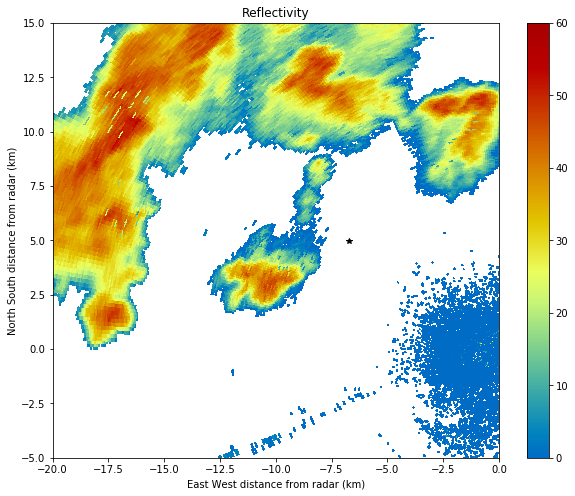

495 142
Time:  2019-09-27 19:09:39
Elevation:  2.4


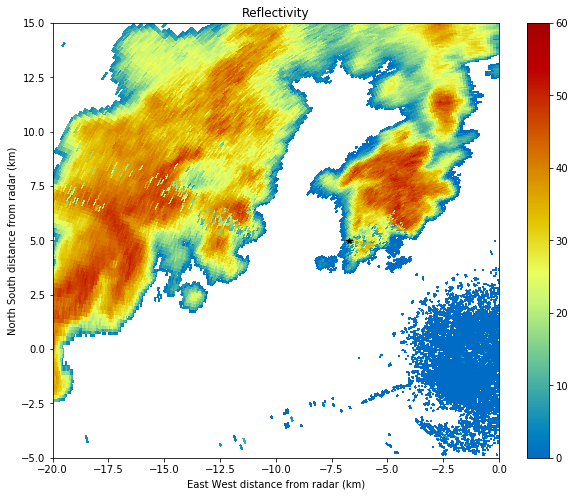

496 142
Time:  2019-09-27 19:14:49
Elevation:  2.4


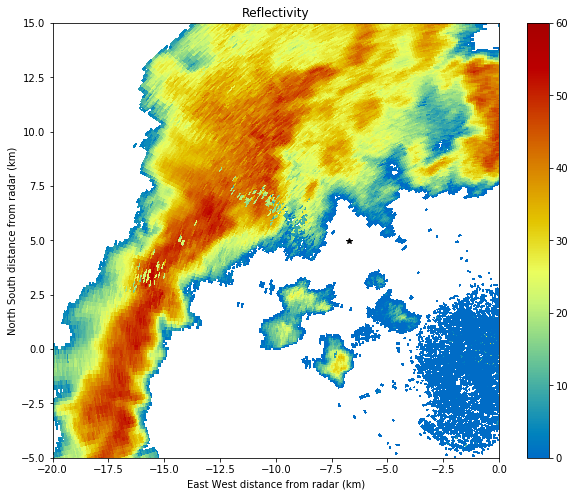

495 142
Time:  2019-09-27 19:19:58
Elevation:  2.4


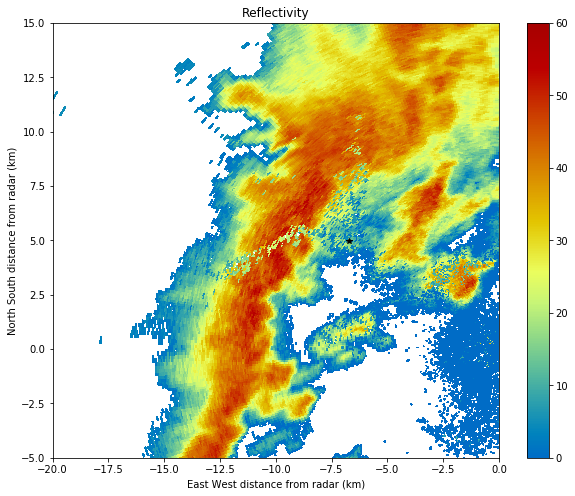

495 142
Time:  2019-09-27 19:25:08
Elevation:  2.4


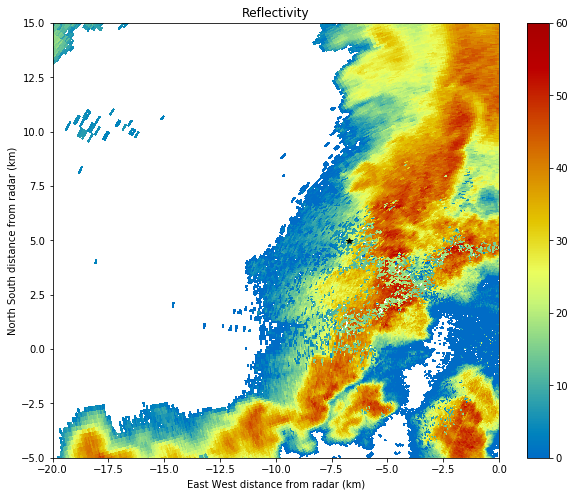

495 142
Time:  2019-09-27 19:30:17
Elevation:  2.4


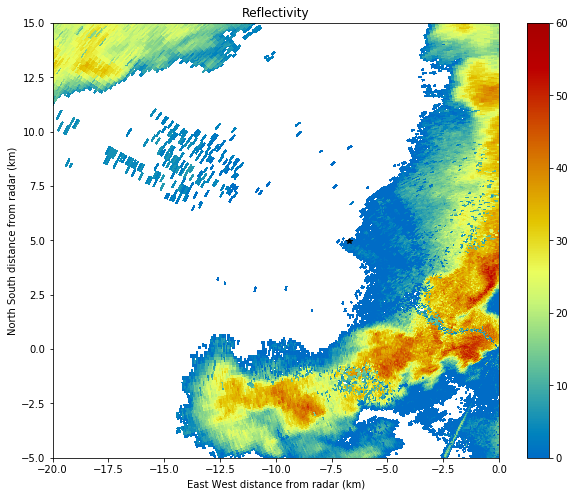

495 142
Time:  2019-09-27 19:35:27
Elevation:  2.4


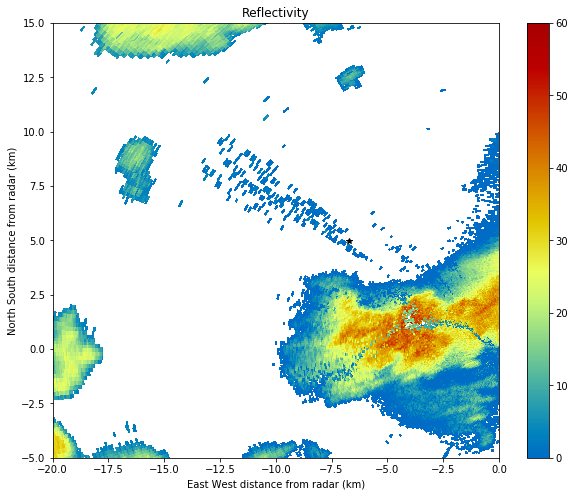

495 142
Time:  2019-09-27 19:40:37
Elevation:  2.4


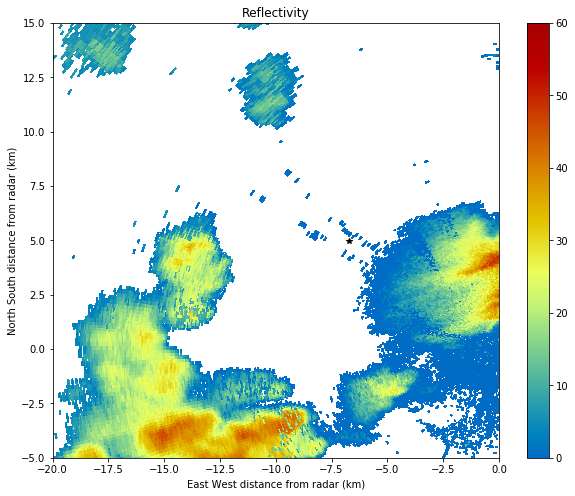

495 142
Time:  2019-09-27 19:45:46
Elevation:  2.4


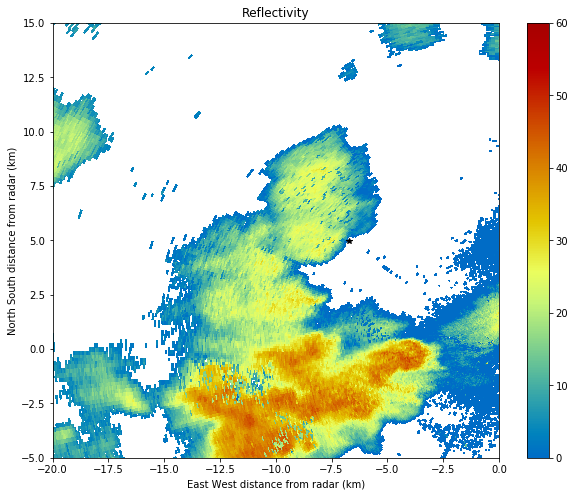

495 142
Time:  2019-09-27 19:50:56
Elevation:  2.4


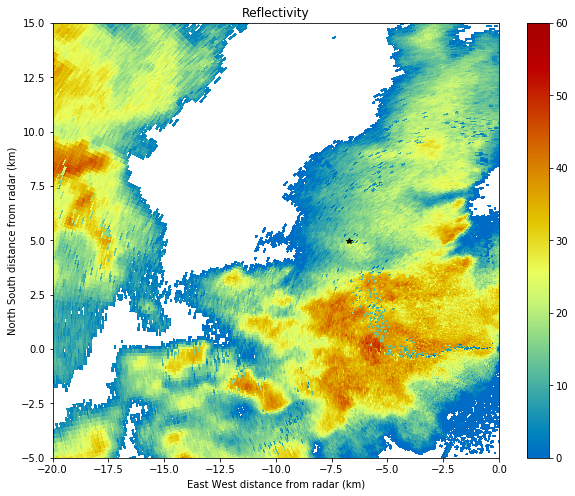

495 142
Time:  2019-09-27 19:56:06
Elevation:  2.4


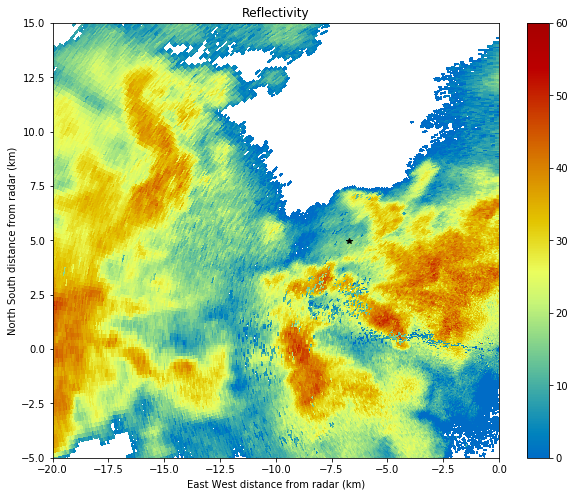

495 142
Time:  2019-09-27 20:01:15
Elevation:  2.4


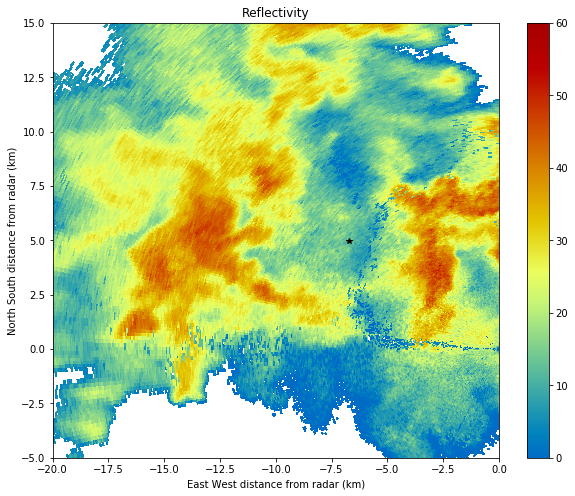

495 142
Time:  2019-09-27 20:06:25
Elevation:  2.4


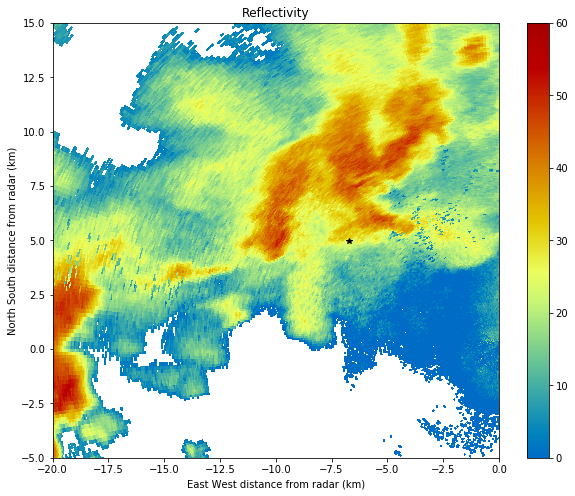

495 142
Time:  2019-09-27 20:11:35
Elevation:  2.4


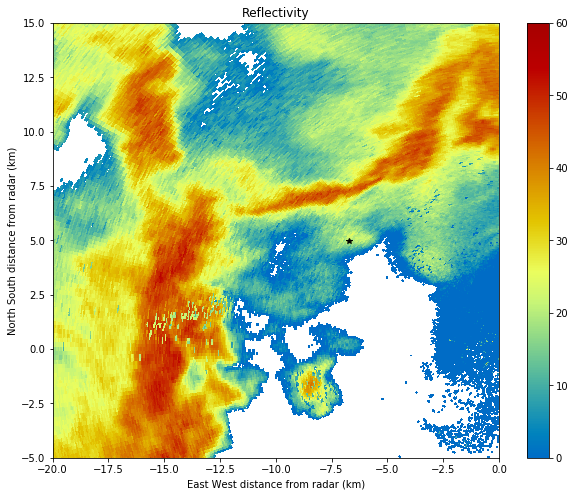

495 142
Time:  2019-09-27 20:16:44
Elevation:  2.4


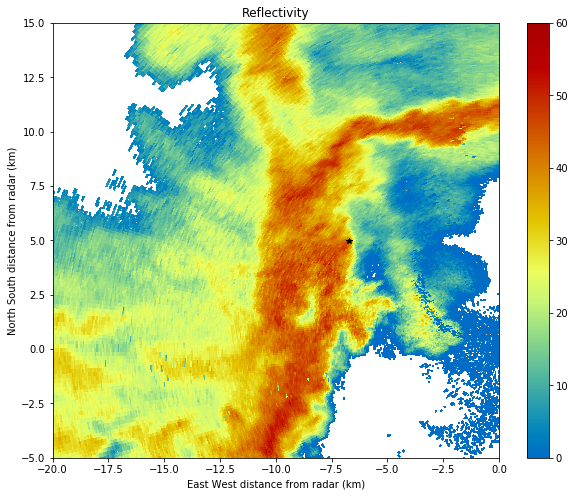

495 142
Time:  2019-09-27 20:21:54
Elevation:  2.4


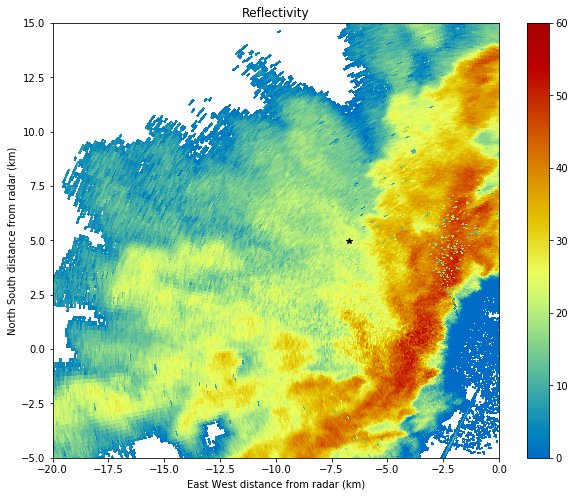

496 142
Time:  2019-09-27 20:27:03
Elevation:  2.4


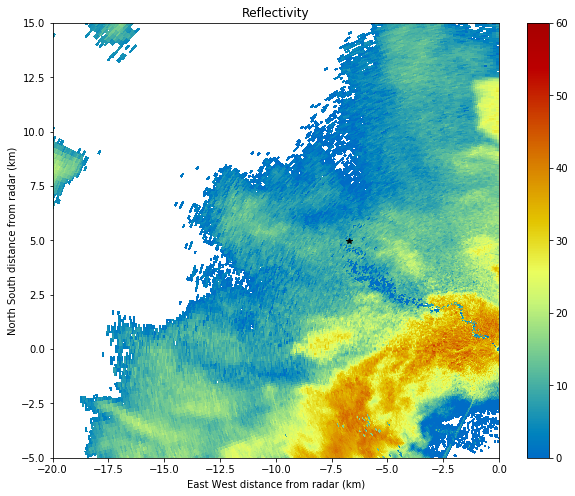

495 142
Time:  2019-09-27 20:32:13
Elevation:  2.4


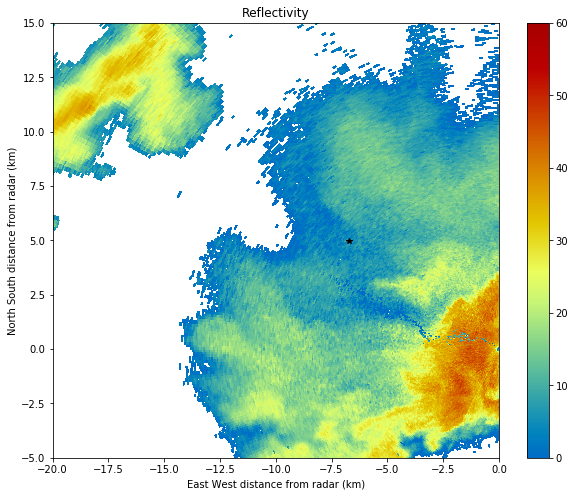

496 142
Time:  2019-09-27 20:37:23
Elevation:  2.4


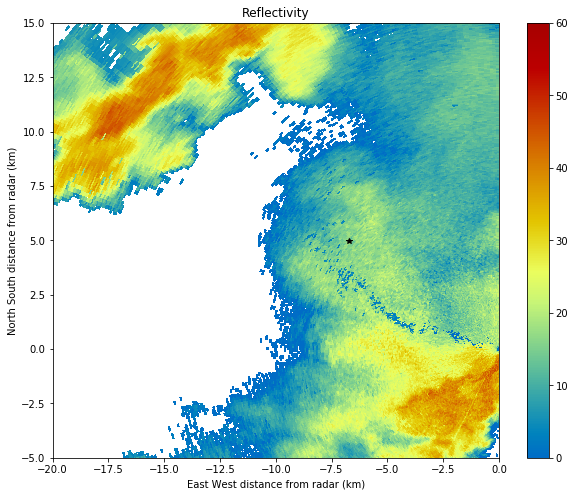

495 142
Time:  2019-09-27 20:42:32
Elevation:  2.4


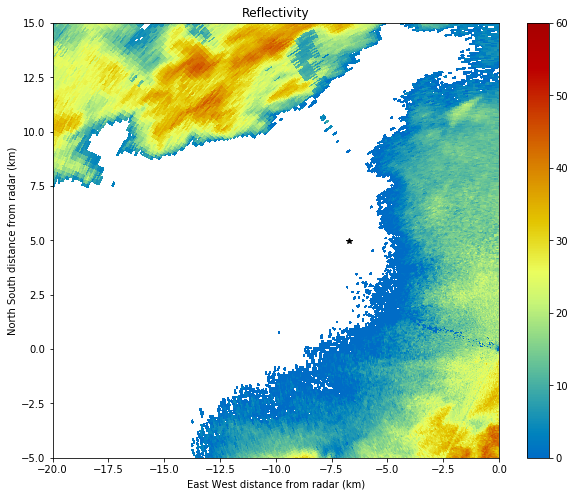

494 142
Time:  2019-09-27 20:47:42
Elevation:  2.4


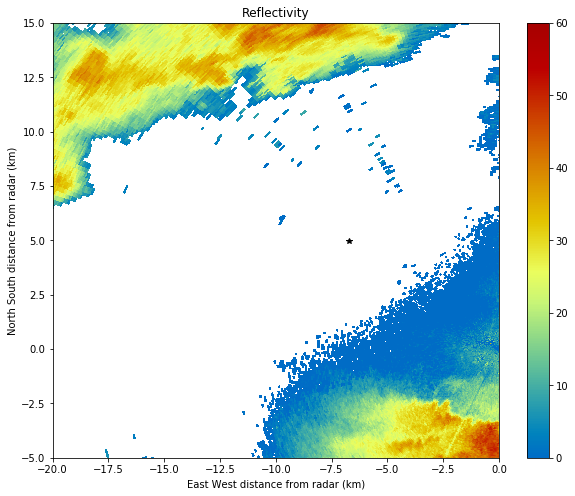

495 142
Time:  2019-09-27 20:52:52
Elevation:  2.4


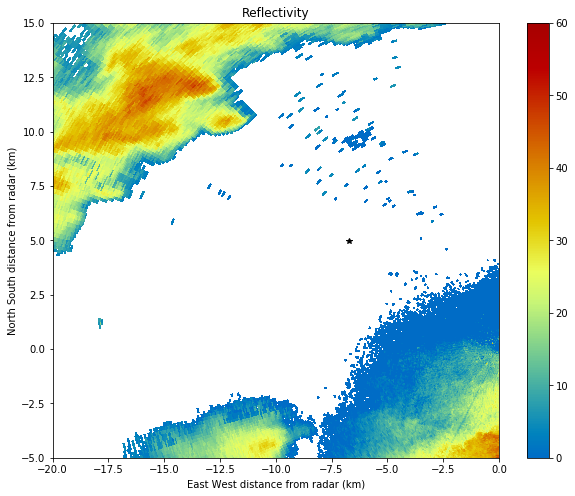

495 142
Time:  2019-09-27 20:58:01
Elevation:  2.4


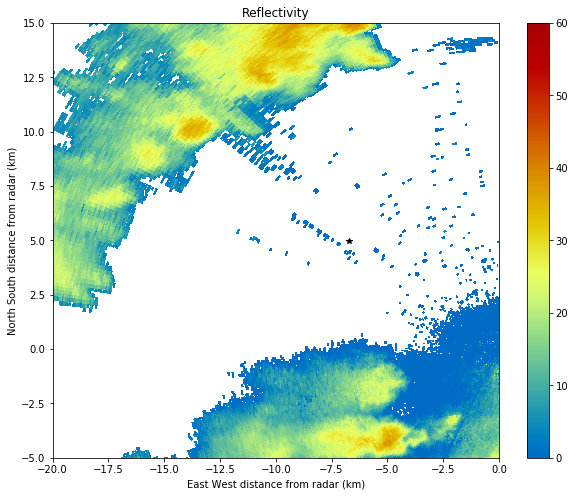

In [21]:
import pyart

for radar_obj, sweeptime in zip(radar_dict['radarsweeplist'], sweeptimes2):
    xrad, yrad, zrad = radar_obj.get_gate_x_y_z(0)
    distance = np.sqrt((PIPS_rad_loc[0] - xrad)**2. + (PIPS_rad_loc[1] - yrad)**2.)
    theta_index, range_index = np.unravel_index(distance.argmin(), distance.shape)

    print(theta_index, range_index)

    display = pyart.graph.RadarDisplay(radar_obj)
    fig = plt.figure(figsize=(10, 8))

    # plot reflectivity
    ax = fig.add_subplot(111)
    print("Time: ", sweeptime)
    print("Elevation: ", radar_obj.elevation['data'][-1])
    display.plot('reflectivity', 0, title='Reflectivity',
                 vmin=0, vmax=60, colorbar_label='', ax=ax)
    # plot ZDR
    
#     display.plot('differential_reflectivity', 0, title='ZDR',
#                  vmin=0, vmax=6, colorbar_label='', ax=ax)
    display.plot_range_ring(radar_obj.range['data'][-1]/1000., ax=ax)
    #display.set_limits(xlim=(-250, 250), ylim=(-250, 250))
    display.set_limits(xlim=(-20, 0), ylim=(-5, 15), ax=ax)
    ax.plot(PIPS_rad_loc[0]/1000., PIPS_rad_loc[1]/1000., 'k*')
    #ax.plot(xrad[theta_index, range_index]/1000., yrad[theta_index, range_index]/1000., 'rx')
    #ax.contourf(xrad / 1000., yrad / 1000., distance)
    #ax.text(PIPS_rad_loc[0] / 1000. - 5., PIPS_rad_loc[1] / 1000., 'PIPS1A', fontsize=10, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()

In [ ]:
radar_obj = radar_dict['radarsweeplist'][0]
print(radar_obj.info())

In [ ]:
print(radar_obj.fields['reflectivity'])